[View in Colaboratory](https://colab.research.google.com/github/3catz/time_series_LSTMS/blob/master/Time_Series_Forecasting_architectures_using_EMD_and_Fully_Convolutional_Neural_Networks_Geomagnetic.ipynb)

# TIME SERIES FORECASTING -- using Empirical Mode Decomposition with Fully Convolutional Neural Networks on a Geomagnetic Time Series. 


# Summary:# 
A noisy time series is additively decomposed into Intrinsic Mode Functions--oscillating, orthogonal basis functions, using the Empirical Mode Decomposition method pionered by Norden Huang. The IMF components are then used as features for a deep convolutional neural network, which can "learn" the decomposition--divide and conquer--and thereby improve forecasting performance and offer not only forecasting for the series but also the IMF components going into the future. This allows us to focus on forecasting physically significant or interesting IMFs. Note: This is additive, not multiplicative decomp.

Using a fully convolutional network with 2 layers for feature extraction and one layer at the end for deconvolution, we predict the a vector containing the forecast for each of the IMF components in the next step. Since the EMD is an additive decomposition of a time series, we can then add these individual points together to get a forecast for the next point. We can achieve over a 95% R2 score on an out of sample prediction test (after 20 epochs of training). Therefore, we can also predict how the future IMFs will look, allowing us to peek into the future to see what IMF components might be more significant in the time horizon we are interested in. 

# Data#

**SPIDR geomagnetic**

I downloaded this data from [comp-engine.org](https://www.comp-engine.org/#!visualize/1fb0f727-3872-11e8-8680-0242ac120002). It has something to do with magnetic fields though I'm not sure what...

In [1]:
!pip install pyhht
!pip install PeakUtils
from sklearn.preprocessing import MinMaxScaler, RobustScaler 
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

#import pandas_datareader.data as web
from pandas import Series
from pandas import DataFrame
from pandas import concat
import matplotlib.pyplot as plt
import os 
from scipy.integrate import odeint
#keras
from keras.models import *
from keras.layers import * 
from keras.optimizers import *
from keras.callbacks import *
from keras import backend as K
from keras.engine.topology import Layer
import peakutils
#!pip install pyramid-arima
#from pyramid.arima import auto_arima

  Running setup.py bdist_wheel for PeakUtils ... - done
  Stored in directory: /root/.cache/pip/wheels/47/a5/7e/f1f31e3a04014971676dcbd1ec1becb97e047a10f57d9a531b
Successfully built PeakUtils


Using TensorFlow backend.


# Utilities: series to supervised, attention with context

In [0]:
def series_to_supervised(data, n_in, n_out, dropnan=True):

	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

# Loading Data 

In [40]:
from google.colab import files    
files.upload()




Saving geomag.csv to geomag.csv


{'geomag.csv': b'0,3,6,4,2,1,1,-2,-2,-1,1,4,6,8,8,9,6,7,7,6,6,4,4,7,6,8,10,13,11,11,10,9,9,9,11,12,13,15,19,18,16,14,17,23,26,23,20,19,19,17,17,16,15,15,12,12,11,13,11,9,13,14,16,16,17,18,18,20,19,20,20,18,18,17,17,15,10,5,5,4,4,3,5,6,4,2,5,5,4,7,10,14,14,14,14,12,11,11,7,8,7,6,5,6,6,8,8,8,9,11,13,15,14,10,7,7,9,14,16,18,20,21,22,25,24,26,30,27,20,22,26,25,9,-4,-7,-6,-6,-5,-5,-5,-3,0,-4,-5,0,1,2,-3,-11,-11,-14,-8,1,0,-11,-7,-9,-15,-23,-24,-18,-13,-15,-12,-10,-14,-17,-19,-24,-29,-25,-20,-23,-37,-33,-28,-21,-17,-18,-19,-20,-15,-14,-17,-17,-16,-14,-13,-14,-14,-15,-16,-16,-18,-19,-12,-11,-14,-16,-17,-15,-11,-9,-12,-13,-5,-4,-6,-4,-2,-1,-3,-5,-6,-7,-8,-8,-8,-10,-7,-7,-8,-11,-8,-5,-3,-4,-1,3,6,7,5,-3,-21,-26,-35,-37,-36,-36,-36,-34,-40,-42,-41,-41,-39,-33,-28,-18,-10,-11,-14,-14,-11,-12,-13,-13,-10,-7,-7,-12,-14,-17,-10,-10,-8,-10,-7,-4,-2,0,1,-3,2,6,4,7,7,7,7,8,10,9,9,11,10,8,5,4,-1,-6,-7,-6,-5,-5,-5,-1,3,1,2,6,9,9,5,8,10,13,12,11,11,10,11,12,9,7,4,1,2,3,3,3,5,9,12,16,16,18,18,19,23,25,27,2

In [0]:
import numpy as np  
data = np.fromfile("yourfilehere.dat", sep = "\n")
print(data)
len(data)


In [41]:
import numpy as np
data = np.genfromtxt("geomag.csv", delimiter = ","); data = np.asarray(data); data.shape

(10000,)

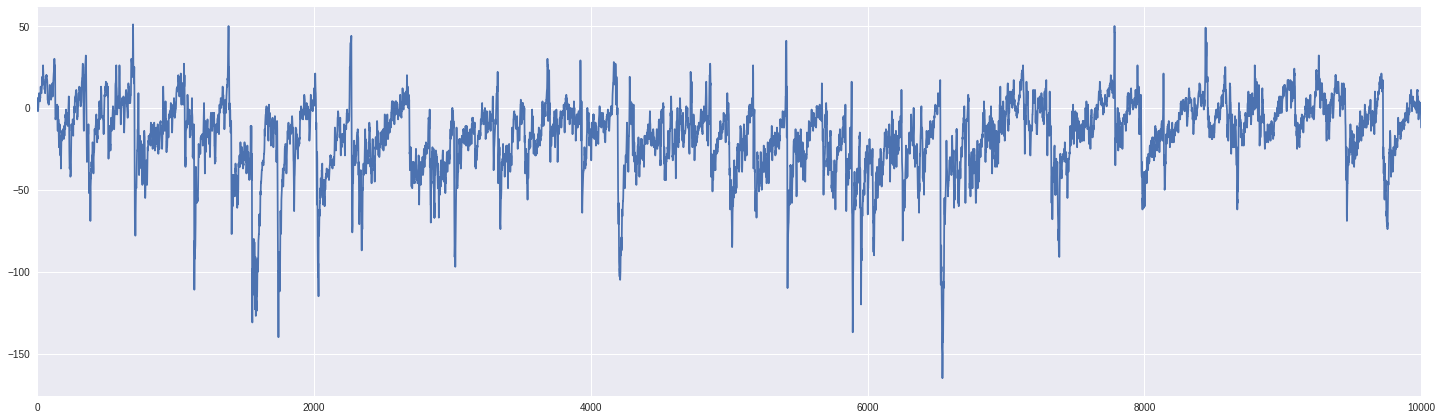

In [42]:
#Plot of Time Series
from scipy.interpolate import interp1d 
plt.figure(figsize=(20,6))
plt.plot(data)
plt.tight_layout()
plt.xlim([0,len(data)])
plt.show()

In [43]:
#Scale the Data to -1,1
scaler = MinMaxScaler(feature_range = (-1,1)) 
scaled_data = scaler.fit_transform(data.reshape(-1,1))
scaled_data.shape
scaled_data = np.squeeze(scaled_data)
scaled_data.shape

(10000,)

In [0]:
scaled_data = np.transpose(scaled_data)

In [0]:
# before you do the EMD, cut out the out of sample part so that the EMDs are not constructed with those future values and information contained within them

in_sample = scaled_data[:-1000]; out_sample = scaled_data[-1000:]

In [46]:
print(in_sample.shape)

(9000,)


#Empirical Mode Decomposition

From Yang et. al (2015), a summary: 
**Empirical mode decomposition (EMD)** technique to decompose the nonstationary signal into a series of intrinsic mode functions (IMFs) [9–11]. This ability makes HHT competitive in processing various composite signals [12–14]. With HHT, complex signals can be decomposed into multiple single-frequency signals that can further be processed by intrinsic mode function of EMD. *After the nonstationary signals have been decomposed into IMFs through EMD, these signals can easily be obtained by Hilbert transform of each mode function*. By doing so, researchers can obtain the instantaneous frequency and amplitude of each IMF. With the Hilbert spectrum and Hilbert marginal spectrum of IMFs, people can accurately get the joint distribution of energy with frequency and time and further predict whether IoT equipment is normal or not. Compared with FFT and VT, HHT is a strong adaptive time frequency analysis method.

In [48]:
from pyhht.emd import EMD 
from pyhht.visualization import plot_imfs

decomposer1 = EMD(in_sample,  maxiter = 2000)
imfs1 = decomposer1.decompose()
bob = decomposer1.keep_decomposing()
ortho = decomposer1.io()
print(ortho)
print(bob)
print("There are a total of %s IMFs" % len(imfs1))

0.12322344266143048
False
There are a total of 12 IMFs


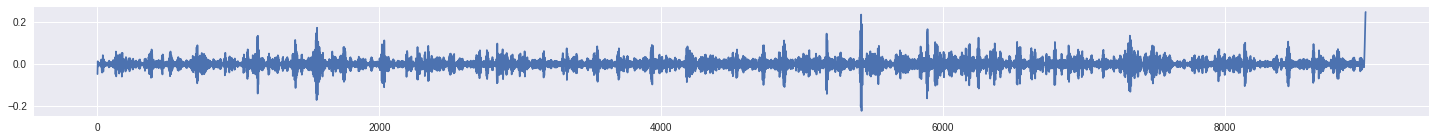

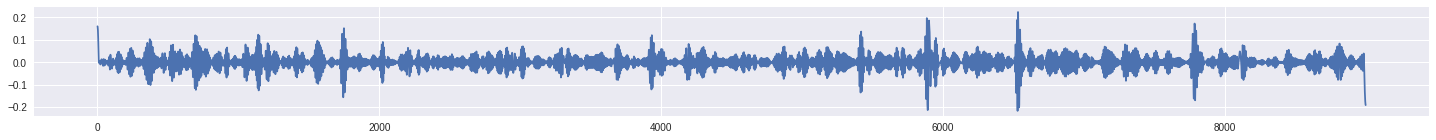

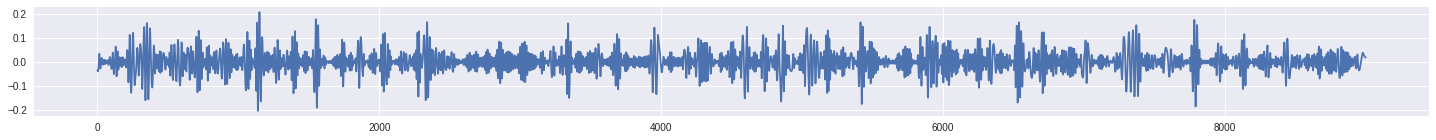

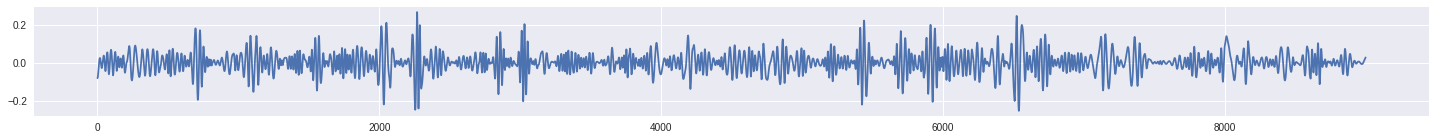

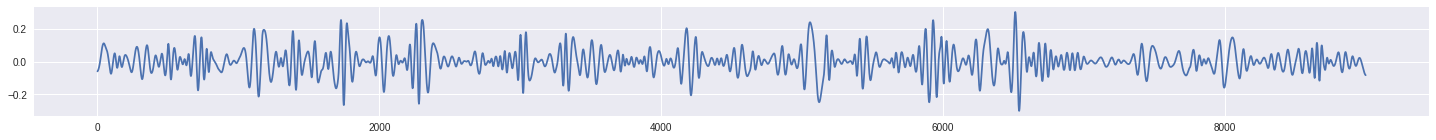

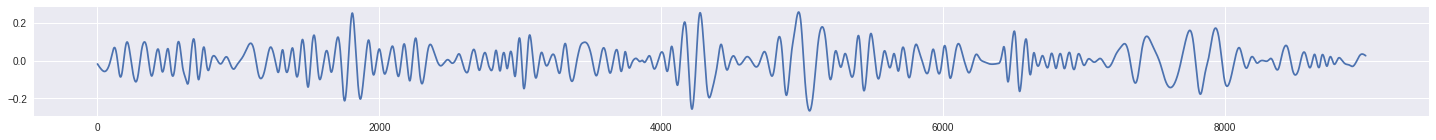

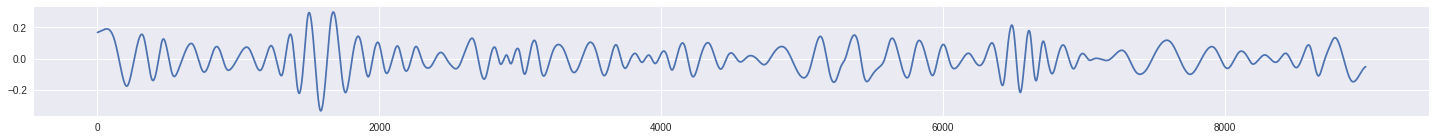

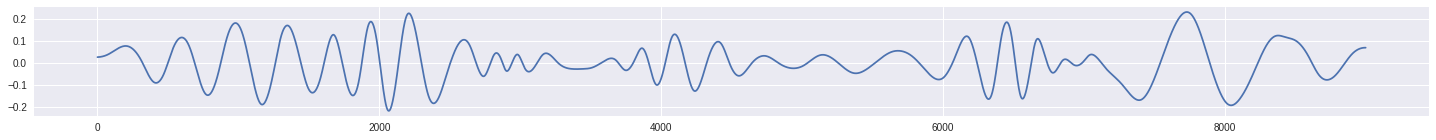

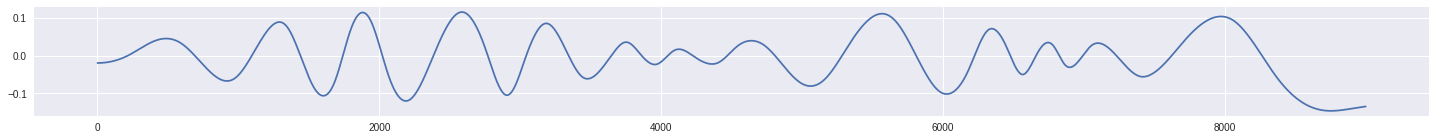

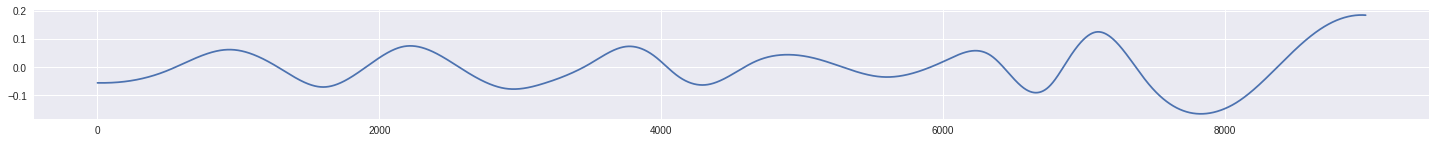

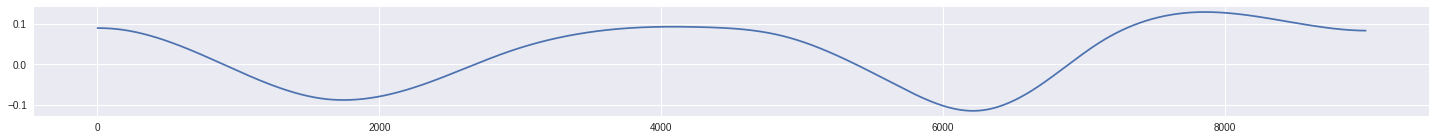

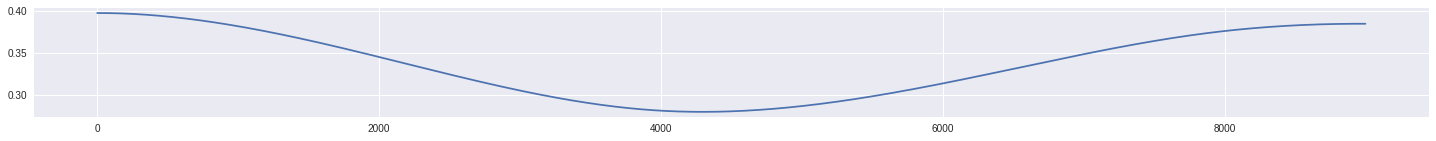

In [49]:
#Plot the IMFs, from highest frequency to lowest. The last one should be a monotonic trend function. It is known as the residue,
#the irreducible trend left after the detrending of the EMD process. 
for i in range(len(imfs1)):
  fig, ax = plt.subplots(figsize=(25,2))
  fig = plt.plot(imfs1[i])
  plt.show()

# HH-transform, instantaneous frequency graph 

In [0]:
import numpy as np
import pylab as plt
from scipy.signal import hilbert

#from PyEMD import EMD


def instant_phase(imfs):
    """Extract analytical signal through Hilbert Transform."""
    analytic_signal = hilbert(imfs)  # Apply Hilbert transform to each row
    phase = np.unwrap(np.angle(analytic_signal))  # Compute angle between img and real
    return phase

t = np.linspace(0,len(scaled_data),len(scaled_data))
dt = 1 
# Extract instantaneous phases and frequencies using Hilbert transform 
instant_phases = instant_phase(imfs1)
instant_freqs = np.diff(instant_phases)/(2*np.pi*dt)

# Create a figure consisting of 3 panels which from the top are the input signal, IMFs and instantaneous frequencies
fig, axes = plt.subplots(3, figsize=(20,18))

# The top panel shows the input signal
ax = axes[0]
ax.plot(t, scaled_data)
ax.set_ylabel("Amplitude [arb. u.]")
ax.set_title("Input signal Channel 1")

# The middle panel shows all IMFs
ax = axes[1]
for num, imf in enumerate(imfs1):
    ax.plot(t, imf, label='IMF %s' %(num+1))

# Label the figure
ax.legend()
ax.set_ylabel("Amplitude [arb. u.]")
ax.set_title("IMFs")

# The bottom panel shows all instantaneous frequencies
ax = axes[2]
for num, instant_freq in enumerate(instant_freqs):
    ax.plot(t[:-1], instant_freq, label='IMF %s'%(num+1))

# Label the figure
ax.legend()
ax.set_xlabel("Time [s]")
ax.set_ylabel("Inst. Freq. [Hz]")
ax.set_title("Huang-Hilbert Transform")

plt.tight_layout()
plt.savefig('hht_example', dpi=120)
plt.show()


# Creating Datasets


*Raw Data, using a certian number of lags; most of my experimentation has beeen with either 10 or 20.

In [50]:
in_sample = in_sample.reshape(-1,1); print(in_sample.shape)

(9000, 1)


In [0]:
lookback = 10
data_f = series_to_supervised(in_sample, n_in = lookback, n_out = 1, dropnan = True)

In [52]:
# this is the raw data, broken into sequences of 20 that result in sequence of 1.
print(data_f.shape)
data_f = np.asarray(data_f)
Xr = data_f[:,:-1]
Y = data_f[:,-1]
print(Xr.shape, Y.shape)

(8990, 11)
(8990, 10) (8990,)


# Use the IMFs--which are time series of equal length as the original signal, as features for convolutional/recurrent network.

In [53]:
imfs1.shape
imfs1 = np.transpose(imfs1, (1,0)); imfs1.shape

(9000, 12)

In [54]:
imf_df = series_to_supervised(imfs1, n_in = lookback, n_out = 1, dropnan = True)
imf_df = np.expand_dims(imf_df, axis = 1)
print(imf_df.shape)

(8990, 1, 132)


In [55]:
imf_df = np.reshape(imf_df, (imf_df.shape[0], (lookback +1), imfs1.shape[-1]))

print(imf_df.shape)


(8990, 11, 12)


In [56]:
targets = imf_df[:,-1,:]
print(targets.shape)

(8990, 12)


In [57]:
print(Xr.shape) 

(8990, 10)


In [58]:
#so reshape everything properly
input_data = np.reshape(Xr, (targets.shape[0],1,lookback))
targets = np.reshape(targets,(targets.shape[0],1,targets.shape[1]))
print(input_data.shape, targets.shape)

(8990, 1, 10) (8990, 1, 12)


In [59]:
#test Y values--completely out of sample. The calculation of the IMFs
#was not influenced by these values. No information contamination from future to past.

out_df = series_to_supervised(out_sample.reshape(-1,1), n_in = lookback, n_out = 1, dropnan = True)
print(out_df.shape); out_df = np.asarray(out_df)
testY = out_df[:,-1]
testX = out_df[:,:-1]

testX = np.expand_dims(testX, axis = 1)
print(testX.shape,testY.shape)

(990, 11)
(990, 1, 10) (990,)


# Partial autocorrelation 

If you were doing SARIMA analysis, you would want to know if this series is autoregressive and to what extent. this helps when calculating a good lag for prediction. The PACF here indicates that this is an autoregressive series of degree 3, meaning that the t-1, t-2, t-3 terms are correlated the the t-term in the time series. 

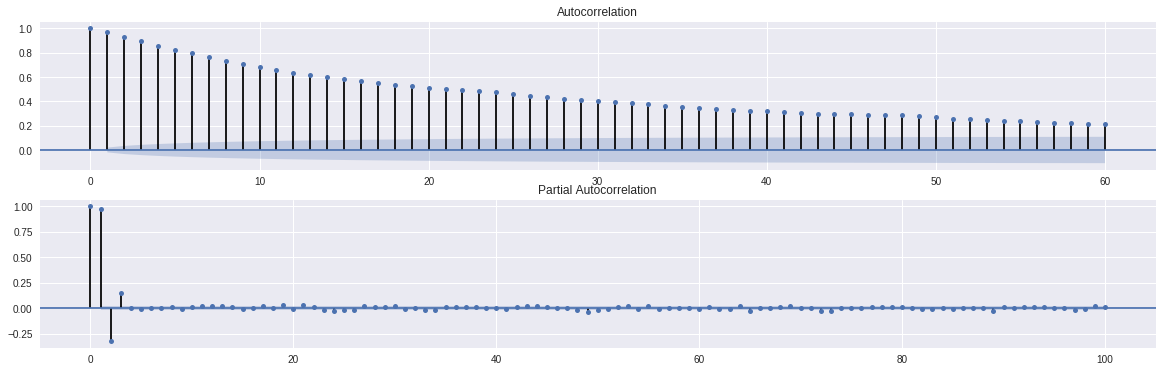

In [127]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

fig, axes = plt.subplots(2, figsize=(20,6))
fig1 = plot_acf(scaled_data,lags = 60, ax = axes[0])
fig2 = plot_pacf(scaled_data, lags = 100, ax = axes[1])
plt.show()

# Network Architecture and Model fitting 

In [124]:
from keras.layers.advanced_activations import *
from keras.regularizers import l1, l2 
from sklearn.metrics import r2_score
import keras.backend as K
from keras.layers import ConvLSTM2D
from keras.layers import LeakyReLU
np.random.seed(2018) #inputs are (1, 20) and outputs are #(1 time step,17 features)

def convs(c, n, f, r, a, bn):
  c = Conv1D(n, f, padding = "causal", dilation_rate = r, activation = a)(c)
  if bn == True:
    c = BatchNormalization()(c)
  return c

inputs = Input(shape = (1, lookback))


x = convs(inputs, 128, 3, 4, "tanh", bn = False)
y = convs(inputs, 128, 3, 16, "tanh", bn = False)

z = concatenate([inputs, x, y], axis = -1)

predictions = convs(z, 12, 3, 1,"tanh", bn = False)



model = Model(inputs = inputs, outputs = predictions)
opt = adam(lr = 1e-3, clipnorm = 1.)
reduce_lr = ReduceLROnPlateau(monitor='loss', factor = 0.9, patience = 3, min_lr = 1e-5, verbose = 1)
checkpointer = ModelCheckpoint(filepath = "timeseries_weights.hdf5", verbose = 1, save_best_only = True)
early = EarlyStopping(monitor = 'loss', min_delta = 1e-4, patience = 10, verbose = 1)

model.compile(optimizer=opt, loss='mse', metrics = [])
model.summary()

history = model.fit(input_data, targets, 
          epochs = 20, 
          batch_size = 128, 
          verbose = 1, 
          #validation_data = (validX, validY),
          callbacks = [reduce_lr, early],
          shuffle = False)  


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_24 (InputLayer)           (None, 1, 10)        0                                            
__________________________________________________________________________________________________
conv1d_68 (Conv1D)              (None, 1, 128)       3968        input_24[0][0]                   
__________________________________________________________________________________________________
conv1d_69 (Conv1D)              (None, 1, 128)       3968        input_24[0][0]                   
__________________________________________________________________________________________________
concatenate_23 (Concatenate)    (None, 1, 266)       0           input_24[0][0]                   
                                                                 conv1d_68[0][0]                  
          

(990, 1)


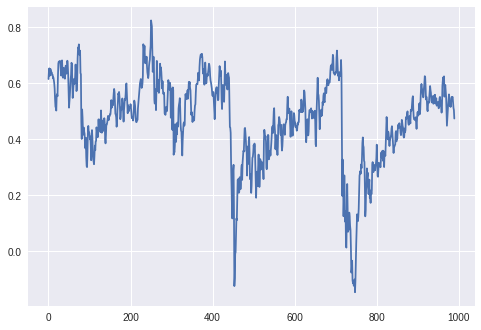

In [125]:
preds = model.predict(testX, batch_size = 1)
summed = np.sum(preds, axis = -1); print(summed.shape)
test_preds = summed[:,0]
plt.plot(test_preds)

# R2 analysis#
In statistics, the coefficient of determination, denoted R2 or r2 and pronounced "R squared", is the proportion of the variance in the dependent variable that is predictable from the independent variable(s).

It is a statistic used in the context of statistical models whose main purpose is either the prediction of future outcomes or the testing of hypotheses, on the basis of other related information. It provides a measure of how well observed outcomes are replicated by the model, based on the proportion of total variation of outcomes explained by the model.[1][2][3]

Final R2 Score is: 0.956333285781395


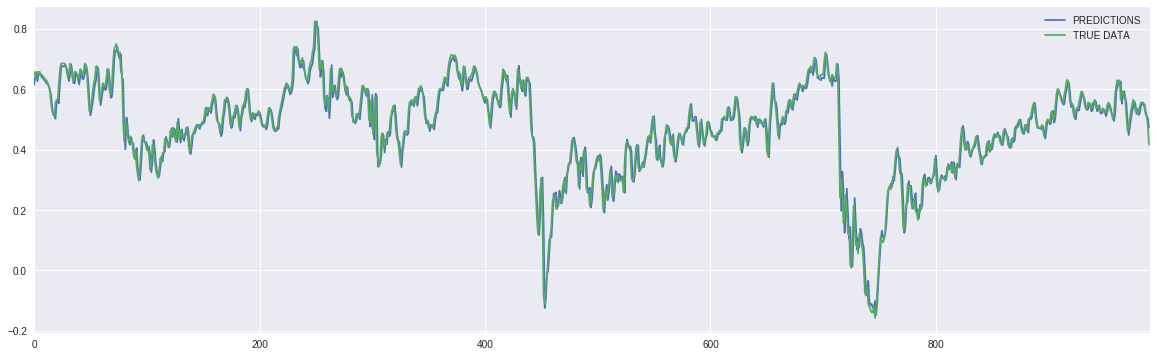

In [128]:
print("Final R2 Score is: {}".format(r2_score(testY, test_preds)))

fig = plt.figure(figsize = (20,6))
fig = plt.plot(test_preds, label = "PREDICTIONS")
fig = plt.plot(testY, label = "TRUE DATA")
plt.xlim([0, 990])
plt.legend()
plt.show()

plt.clf()
plt.cla()
plt.close()